In [1]:
import xarray as xr
import matplotlib.pyplot as plt

In [11]:
xr.open_dataset('Tmax/heatwave.nc')

<xarray.Dataset>
Dimensions:    (time: 12053, longitude: 144, latitude: 84)
Coordinates:
  * time       (time) datetime64[ns] 1983-01-01 1983-01-02 ... 2015-12-31
  * longitude  (longitude) float32 -19.88 -19.62 -19.38 ... 15.38 15.62 15.88
  * latitude   (latitude) float32 4.125 4.375 4.625 4.875 ... 24.38 24.62 24.88
Data variables:
    Tmax       (time, latitude, longitude) float32 ...
Attributes: (12/15)
    CDI:            Climate Data Interface version 2.0.4 (https://mpimet.mpg....
    Conventions:    CF-1.6
    institution:    Climate Hazards Center.  University of California at Sant...
    title:          dataVersion 1.0
    history:        Sun Aug 27 14:47:56 2023: cdo gec,1 mask.nc heatwave.nc\n...
    version:        Version 1.0
    ...             ...
    comments:       downscaled to daily using ERA5
    ftp_url:        ftp://ftp.chc.ucsb.edu/pub/org/chc/products/CHIRTSdaily/v...
    https_url:      https://chc.ucsb.edu/data/chirtsdaily
    reference1:     Verdin, A. et al. Development and validation of the CHIRT...
    reference2:     Funk, C. et al. A high-resolution 1983–2016 Tmax climate ...
    CDO:            Climate Data Operators version 2.0.4 (https://mpimet.mpg....

In [ ]:
ds = xr.open_dataset('Tmax/heatwave.nc').Tmax

In [ ]:
ds.groupby('time.year').sum('time').mean('year').plot(vmin = 70, cmap = 'plasma', extend = 'both')
plt.title('Yearly number of heatwaves HWN')

In [ ]:
ds_90 = xr.open_dataset('Tmax/CHIRTS_Tmax90_WA_1983_2016_10_day_window.nc').sortby('time')
ds_tx = xr.open_dataset('Tmax/CHIRTS_Tmax_WA_1983_2016.nc').sortby('time')

In [ ]:
ds_tm = xr.open_dataset('Tmean/CHIRTS_Tmean_WA_1983_2016.nc').sortby('time').drop_duplicates('time


In [ ]:
longitude = 0
latitude = 12
def sel_lonlat(ds):
    dt = ds.sel(longitude=longitude, latitude = latitude, method ='nearest')
    return dt

In [ ]:
sel_lonlat(ds_tx).Tmax.plot(label='tx')
sel_lonlat(ds_90).Tmax.plot(label = 'tx90')
plt.legend()

In [ ]:
# ds_tx.sel(time=slice('1983-01-01','2016-12-26'))
ds_90.drop_duplicates('time')

In [ ]:
mask = ds_tx.sel(time=slice('1983-01-01','2016-12-26')) > ds_90.drop_duplicates('time')

In [ ]:
ctx90 = ds_tx.sel(time=slice('1983-01-01','2016-12-26')).where(mask)

In [ ]:
ctx90.Tmax.groupby('time.year').count('time').mean('year').plot(cmap = 'plasma', extend = 'both')

In [ ]:
ctx90.Tmax.groupby('time.season').count('time').sel(season='DJF').plot(vmax =6, cmap = 'plasma' , extend = 'both')

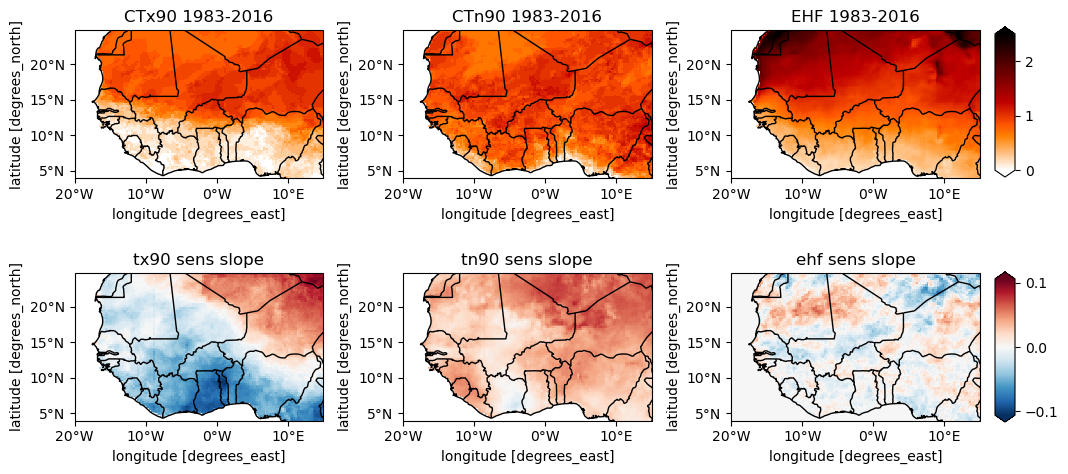

In [28]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy as cp
from cartopy import crs, feature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import numpy as np
import pymannkendall as mk
import warnings
warnings.filterwarnings('ignore')

path1='/media/kenz/1B8D1A637BBA134B/CHIRTS'

def set_fig_params(axes):
    for i,j in enumerate(axes):
    # for i in (range(0,len(axes))):
        ax[i].set_extent([-19,15,4,24])
        ax[i].add_feature(feature.COASTLINE)
        ax[i].add_feature(feature.BORDERS)
        ax[i].add_feature(feature.STATES, linewidth = 0.2)
        ax[i].set_xticks([-20,-10,0,10], crs=crs.PlateCarree())
        ax[i].set_yticks([5,10,15,20], crs=crs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax[i].xaxis.set_major_formatter(lon_formatter)
        ax[i].yaxis.set_major_formatter(lat_formatter)

        
def sens_slope(data):
    data = data.groupby('time.year').mean('time')
    data = data.sel(longitude=np.arange(-19.875, 21.875,0.25), latitude=np.arange(3.125,26.875,0.25), method = 'nearest')
    output=[]
    for i in np.arange(len(data.latitude.values)):
        for j in np.arange(len(data.longitude.values)):
            try:
                slope_val = mk.sens_slope(data[:,i,j]).slope
            except:
                slope_val = np.nan
            output.append(slope_val)

    output = np.copy(output).reshape(data.latitude.size,data.longitude.size)
    slopes=xr.DataArray(output, dims=('latitude','longitude'), coords={'latitude':data.latitude,'longitude':data.longitude})
    return slopes

fig, ax = plt.subplots(ncols = 3, nrows=2, figsize = (10,5), subplot_kw={'projection':crs.PlateCarree()})
ax = ax.flatten()
set_fig_params(ax)
# /media/kenz/1B8D1A637BBA134B/CHIRTS/Tmax/CHIRTS_Tmax_90.nc
tx90 = xr.open_dataset(path1+'/Tmax/chirts.Tmax90.1983.2016.WA.days_p25.nc').Tmax.sortby('time').drop_duplicates('time')
# /media/kenz/1B8D1A637BBA134B/CHIRTS/Tmean/chirts.Tmean.1983.2016.WA.days_p25.nc
tx = xr.open_dataset(path1+'/Tmax/chirts.Tmax.1983.2016.WA.days_p25.nc').Tmax.sortby('time').drop_duplicates('time')
mask = tx > tx90#.drop_duplicates('time')
ctx90 = tx.where(mask)
cc = 'gist_heat_r'
ctx90 = ctx90.groupby('time.year').count('time').mean('year').plot(ax = ax[0], vmax =2.5,
                                                                   cmap = cc, add_colorbar = False)
ax[0].set_title('CTx90 1983-2016')
tn90 = xr.open_dataset(path1+'/Tmin/chirts.Tmin90.1983.2016.WA.days_p25.nc').Tmin.sortby('time').drop_duplicates('time')
tn = xr.open_dataset(path1+'/Tmin/chirts.Tmin.1983.2016.WA.days_p25.nc').Tmin.sortby('time').drop_duplicates('time')
mask = tn > tn90
ctn90 = tn.where(mask)
ctn90 = ctn90.groupby('time.year').count('time').mean('year').plot(ax = ax[1],vmax=2.5, 
                                                                   cmap = cc, add_colorbar = False)

ax[1].set_title('CTn90 1983-2016')

EHF = xr.open_dataset('scripts/EHF.nc')

cb1 = abs(EHF.Tmax.mean('time')).plot(ax = ax[2], cmap = cc,vmax = 2.5, add_colorbar=False)#, extend = 'both', vmax = 2, shrink = 0.8)
ax[2].set_title('EHF 1983-2016')
cm = 'RdBu_r'
tx90_s = sens_slope(tx90)
tx90_s.plot(ax = ax[3], cmap = cm, add_colorbar=False)
ax[3].set_title('tx90 sens slope')

tn90_s = sens_slope(tn90)
cb2 = tn90_s.plot(ax = ax[4], cmap = cm, add_colorbar=False)
ax[4].set_title('tn90 sens slope')


ehf_s = sens_slope(EHF.Tmax)
ehf_s.plot(ax = ax[5], cmap = cm, add_colorbar=False)
ax[5].set_title('ehf sens slope')
cb = [cb1,cb2]
for i,j in enumerate([0.62,0.13]):
    cax = fig.add_axes([1,j,0.02,0.3])
    fig.colorbar(cb[i], cax=cax, orientation='vertical', extend = 'both')
# fig.colorbar(shrink=0.8)
### plt.suptitle('Climatologies and trends for HWN')
fig.tight_layout()
plt.savefig(path1+'/figures/graph1.jpeg', bbox_inches='tight')

In [ ]:
"""Constants.py
   Class that contains most used atmospheric constant values
   Created: 08 August 2013
   Modified: Mon Aug  4 16:01:41 EST 2014: Added cv, kappa, L, constants for moist adiabatic lapse rate
   Aug 11 2014 => Added secinday. Roman Olson, CCRC, UNSW.
   Modified: Sat Mar  7 23:17:43 AEDT 2015: Added earth radius. Daniel Argueso, CCRC, UNSW.
   
"""


class const:
    Rd = 287.04  # gas constant air (dry)
    Rv = 461.5  # gas constant vapor
    cp = 7.0 * Rd / 2.0
    cv = 718.0
    epsilon_gamma = 0.62197
    es_base_bolton = 611.2  # Pa
    es_Abolton = 17.67  #
    es_Bbolton = 243.5  # degC
    es_base_tetens = 6.1078
    es_Atetens_vapor = 7.5
    es_Btetens_vapor = 237.3
    es_Atetens_ice = 9.5
    es_Btetens_ice = 265.5
    g = 9.81
    p1000mb = 100000.0
    rcp = Rd / cp
    tkelvin = 273.15
    missingval = -9999.0
    kappa = (cp - cv) / cp
    L = 2.501e6  # latent heat of vaporization
    # Constants used to calcualte moist adiabatic lapse rate
    # Formula 3.16 in Rogers&Yau (from Geir Arne Waagboe ;http://code.google.com/p/pywrfplot/)
    a = 2.0 / 7.0
    b = epsilon_gamma * L * L / (Rd * cp)
    c = a * L / Rd
    secinday = 86400  # Number of seconds in a day
    earth_radius = 6371000  # Earth radius in m

In [ ]:
#!/usr/bin/env python

""" compute_EHFheatwaves

Author: Daniel Argueso @ CCRC, UNSW. Sydney (Australia)
email: d.argueso@ unsw.edu.au
Created: Wed Jun 24 11:21:31 AEST 2015 - from compute_EHFheatwaves.py

Yearly maximum heatwave intensity (HWA)
Yearly average heatwave intensity (HWM)
Yearly number of heatwaves        (HWF)
Yearly number of heatwave days    (HWN)
Duration of yearly longest heatwave (HWD)
Timing of the first heatwave      (HWT)
Percentile use to determine extremes (either 90th or 95th depending on the method) (pct)
Array with daily EHF index (EHF)
Temperature equivalent to HWM (HWMt)
Temperature equivalent to HWA (HWAt)
Index containing the number of consecutive heat wave days (spell_all)
Yearly mean duration of heatwaves (HWL)


Script based on Sarah's matlab script EHF_index.m
Script based on D. Argueso compute_EHFheatwaves.py

Created: 09 September 2013
Modified: 15 October 2013
Modified: Tue Jun 23 15:02:54 AEST 2015 - The code has been simplified and made more efficient.
                                          Some options were removed because they were not necessary (NFR09)
                                          and some hardcoded options were incorporated in a better way.
Modified: Fri Jan 29 11:59:12 AEDT 2016 - Added new method to calculate spells using groups
Modified: 2018-07-25 12:34 - Added NH and SH summer options
"""

import netCDF4 as nc
import numpy as np
# from constants import const
import glob as glob
from itertools import groupby
import datetime as dt

import pdb


def calc_percentile(tave, nyears, thres_file=None, method="NF13", nwindow=15):

    """Function to calculate the percentile that indentifies hot days
    tave: mean daily temperature calcualted from tmax and tmin
    nyears: number of years in the analysed period
    thres_file: file that contains previously calculated percentiles
    method: now two methods are supported depending on how the percentiles are calculated 'NF13' and 'PA13'
    nwindow: number of days for the window used to calculate percentiles in PA13 method
    ---
    output: pct_calc
    """
    if method == "NF13":

        if thres_file == None:
            print("No thresholds file provided, we will calculate them")

            if not isinstance(tave, np.ma.core.MaskedArray):
                pct_calc = np.percentile(tave, 95, axis=0)

            else:
                pct_calc = np.ones(tave.shape[1:], float) * const.missingval
                for i in range(tave.shape[1]):
                    for j in range(tave.shape[2]):
                        aux = tave[:, i, j]
                        if len(aux[~aux.mask].data) != 0:
                            pct_calc[i, j] = np.percentile(
                                aux[~aux.mask].data, 95, axis=0
                            )
        else:
            print("Percentiles are retrieved from the thfile provided")
            pct_file = nc.Dataset(thres_file, "r")
            pct_calc = pct_file.variables["PRCTILE95"][:].astype("float")

    elif method == "PA13":

        if thres_file == None:
            # No percentile file is provided and thus they are calculated from the given data
            print("Percentiles are calculated because no thfile is provided")
            windowrange = np.zeros((365,), dtype=bool)
            windowrange[: int(np.ceil(nwindow / 2))] = True
            windowrange[-int(np.floor(nwindow / 2)) :] = True
            if np.sum(windowrange) != nwindow:
                raise SystemExit(0)
            windowrange = np.tile(windowrange, nyears)
            pct_calc = np.ones((365,) + tave.shape[1:], float) * const.missingval

            if not isinstance(tave, np.ma.core.MaskedArray):
                for d in range(365):
                    pct_calc[d, :, :] = np.percentile(
                        tave[windowrange == True, :, :], 90, axis=0
                    )
                    windowrange = np.roll(windowrange, 1)

            else:
                for i in range(tave.shape[1]):
                    for j in range(tave.shape[2]):
                        for d in range(365):
                            aux = tave[windowrange == True, :, :]
                            if len(aux[~aux.mask].data) != 0:
                                pct_calc[d, :, :] = np.percentile(
                                    aux[~aux.mask].data, 90, axis=0
                                )
                            windowrange = np.roll(windowrange, 1)

        else:
            print("Percentiles are retrieved from the thfile provided")
            # A percentile file is provided and it contains a PRCTILE90 variable
            pct_file = nc.Dataset(thres_file, "r")
            pct_calc = pct_file.variables["PRCTILE90"][:].astype("float")

    else:
        raise ValueError("Method not supported: Choose between NF13 or PA13")

    return pct_calc


def calc_spell(series):

    if isinstance(series, np.ma.core.MaskedArray):
        if np.any(series.mask == True):
            series[series.mask] = -99

    srun = np.zeros(series.shape)
    srun[1:] = np.diff(series, axis=0)
    srun[srun == 99] = -1
    srun[srun == 100] = 1
    srun[0] = -1
    if isinstance(series, np.ma.core.MaskedArray):
        L = (series.data).tolist()
    else:
        L = (series).tolist()
    groups_hw = []

    for k, g in groupby(L):
        if k == 1:
            b = list(g)
            groups_hw.append(sum(b))

    spell_hw = np.zeros((len(series),), dtype=int)
    if np.any(srun == 1):
        spell_hw[srun == 1] = np.asarray(groups_hw)

    ## Keep only spells equal or larger than 3 days

    spell_hw[spell_hw < 3] = 0
    return spell_hw


def compute_EHF(
    tave,
    dates=None,
    thres_file=None,
    bsyear=None,
    beyear=None,
    month_starty=1,
    mask=None,
    method="NF13",
    nwindow=15,
    EHFaccl=False,
    season="yearly",
):
    """Function to calculate Excess Heat Factor (EHF) heatwaves from tave calcualted as (tmax+tmin)/2."""
    if mask == None:
        mask = np.ones(tave.shape[1:], int)

    # PERFORM SOME CHECKS
    ## This is explicitly checked to preserve compatibility across versions
    if (bsyear == None) or (beyear == None):
        sys.exit(
            "ERROR: you didn't provide base period years to compute_EHF function, please revise"
        )

    years_all = np.asarray([dates[i].year for i in range(len(dates))])
    months_all = np.asarray([dates[i].month for i in range(len(dates))])
    days_all = np.asarray([dates[i].day for i in range(len(dates))])

    # If using PA13, leap days need to be removed

    if method == "PA13":

        dates = dates[((months_all == 2) & (days_all == 29)) == False]
        years = np.asarray([dates[i].year for i in range(len(dates))])
        months = np.asarray([dates[i].month for i in range(len(dates))])
        days = np.asarray([dates[i].day for i in range(len(dates))])

        tave = tave[((months_all == 2) & (days_all == 29)) == False, :, :]

    else:

        years = np.asarray([dates[i].year for i in range(len(dates))])
        months = np.asarray([dates[i].month for i in range(len(dates))])
        days = np.asarray([dates[i].day for i in range(len(dates))])

    # Specify when the year start
    # It is important to define seasons (e.g. Souther Hemisphere, month_starty should be in winter)
    new_years = years.copy()
    new_years[months < month_starty] -= 1

    syear = np.min(years)
    eyear = np.max(years)
    nyears = eyear - syear + 1
    nbyears = beyear - bsyear + 1

    shift_pct = np.argmax(new_years == syear)

    ndays = tave.shape[0]
    nlat = tave.shape[1]
    nlon = tave.shape[2]

    # Calculate percentiles over the base period
    pct = calc_percentile(
        tave[(years >= bsyear) & (years <= beyear), :, :],
        nbyears,
        thres_file,
        method=method,
        nwindow=15,
    )

    tave_3days = np.zeros(tave.shape, dtype=float)

    for t in range(2, ndays):
        tave_3days[t, :, :] = np.mean(tave[t - 2 : t + 1, :, :], axis=0)

    if EHFaccl == True:
        tave_30days = np.zeros(tave.shape, dtype=float)
        for t in range(32, ndays):
            tave_30days[t, :, :] = np.mean(tave[t - 32 : t - 2, :, :], axis=0)

            ###############################################
            ###############################################
            ### CALCULATING EHIsig and EHIaccl (if required)

    if method == "PA13":
        EHIsig = np.zeros(tave.shape, dtype=float)
        for t in range(ndays):
            EHIsig[t, :, :] = tave_3days[t, :, :] - pct[(t) % 365, :, :]
    else:
        EHIsig = tave_3days - pct

    if EHFaccl == True:
        EHIaccl = tave_3days - tave_30days

    ###############################################
    ###############################################
    ## CALCULATING EHF and EHF_Exceed

    if EHFaccl == True:
        EHF = np.maximum(1, EHIaccl) * EHIsig
    else:
        EHF = EHIsig
    EHF[EHF < 0] = 0

    EHF_exceed = np.zeros(EHF.shape, dtype=int)
    EHF_exceed[EHF > 0] = 1

    if EHFaccl == True:
        del tave_30days, EHIaccl, EHIsig

    ###### ZEROING DAYS NOT BELONGING TO SUMMER (SH: NOV,DEC,JAN,FEB,MAR; NH: MAY,JUN,JUL,AUG,SEP)
    ###### Originally used only in PA13 method
    if season == "summer_sh":
        EHF_exceed[(months >= 4) & (months <= 10), :, :] = False
        years[(months >= 4) & (months <= 10)] = -99

        ## For heat wave timing purposes
        shift_start_year = (
            dt.datetime(syear, 11, 0o1) - dt.datetime(syear, 0o7, 0o1)
        ).days

    elif season == "summer_nh":
        EHF_exceed[(months >= 10) | (months <= 4), :, :] = False
        years[(months >= 10) | (months <= 4)] = -99
        shift_start_year = 0

    elif season == "yearly":
        shift_start_year = 0
    else:
        raise ValueError(
            "Season not supported: Choose between summer_sh, summer_nh or yearly"
        )

        # Defining variables for heat wave and spell calculation
    heatwave_EHF_avg = np.ones(tave.shape, dtype=float) * const.missingval
    heatwave_EHF_peak = np.ones(tave.shape, dtype=float) * const.missingval
    heatwave_EHF = np.zeros(tave.shape, dtype=bool)
    spell_all = np.zeros(tave.shape, dtype=int)

    for ilat in range(nlat):
        for ilon in range(nlon):
            if mask[ilat, ilon] == 1:
                spell = calc_spell(EHF_exceed[:, ilat, ilon])

                for t in range(ndays):
                    if spell[t] != 0:
                        heatwave_EHF_avg[t, ilat, ilon] = np.mean(
                            EHF[t : t + spell[t], ilat, ilon]
                        )
                        heatwave_EHF_peak[t, ilat, ilon] = np.max(
                            EHF[t : t + spell[t], ilat, ilon]
                        )
                        heatwave_EHF[t : t + spell[t], ilat, ilon] = EHF_exceed[
                            t : t + spell[t], ilat, ilon
                        ]

                spell_all[:, ilat, ilon] = spell

    ### PULLING OUT HW CHARACTERISTICS ###

    heatwave_EHF_avg = np.ma.masked_equal(heatwave_EHF_avg, const.missingval)
    heatwave_EHF_peak = np.ma.masked_equal(heatwave_EHF_peak, const.missingval)

    tave_peak_masked = np.ma.masked_where(heatwave_EHF_peak.mask, tave_3days)
    tave_avg_masked = np.ma.masked_where(heatwave_EHF_avg.mask, tave_3days)

    HWA = np.ones((nyears,) + tave.shape[1:], float) * const.missingval
    HWM = np.ones((nyears,) + tave.shape[1:], float) * const.missingval
    HWN = np.ones((nyears,) + tave.shape[1:], float) * const.missingval
    HWF = np.ones((nyears,) + tave.shape[1:], float) * const.missingval
    HWD = np.ones((nyears,) + tave.shape[1:], float) * const.missingval
    HWT = np.ones((nyears,) + tave.shape[1:], float) * const.missingval
    HWMt = np.ones((nyears,) + tave.shape[1:], float) * const.missingval
    HWAt = np.ones((nyears,) + tave.shape[1:], float) * const.missingval
    HWL = np.ones((nyears,) + tave.shape[1:], float) * const.missingval

    for yr in range(nyears):
        year = yr + syear
        HWA[yr, :, :] = np.ma.max(heatwave_EHF_peak[new_years == year, :, :], axis=0)
        HWM[yr, :, :] = np.ma.mean(heatwave_EHF_avg[new_years == year, :, :], axis=0)
        HWF[yr, :, :] = (
            np.sum(spell_all[new_years == year, :, :], axis=0)
            * 100.0
            / float(np.sum(new_years == year))
        )
        HWN[yr, :, :] = np.sum(spell_all[new_years == year, :, :] != 0, axis=0)
        HWD[yr, :, :] = np.max(spell_all[new_years == year, :, :], axis=0)
        HWL[yr, :, :] = (
            np.ma.sum(spell_all[new_years == year, :, :], axis=0) / HWN[yr, :, :]
        )
        HWT[yr, :, :] = np.argmax(spell_all[new_years == year, :, :] != 0, axis=0)

        HWAt[yr, :, :] = (
            np.ma.max(tave_peak_masked[new_years == year, :, :], axis=0) - const.tkelvin
        )
        HWMt[yr, :, :] = (
            np.ma.mean(tave_avg_masked[new_years == year, :, :], axis=0) - const.tkelvin
        )

    HWT = np.ma.masked_equal(HWT, 0.0)
    HWMt[HWMt == 0] = const.missingval
    HWM[HWM == 0] = const.missingval
    HWL[HWN == 0] = const.missingval
    HWA[HWA == 0] = const.missingval
    HWAt[HWAt == 0] = const.missingval

    return HWA, HWM, HWF, HWN, HWD, HWT, pct, EHF, HWMt, HWAt, spell_all, HWL

In [ ]:
import pytest
import xarray as xr
import pandas as pd
import datetime as dt
from constants import const
# from compute_EHFheatwaves import compute_EHF


def test_EHF():

    # fin = xr.open_dataset("./test.nc")
    # fout_index = xr.open_dataset("./testout_index.nc")
    fin = xr.open_dataset('CHIRTS_Tmean_WA_1983_2016.nc')

    tave = fin.tas.values
    dt64 = fin.time.values
    dates = pd.to_datetime(dt64)

    (
        HWA,
        HWM,
        HWF,
        HWN,
        HWD,
        HWT,
        pctcalc,
        EHFindex,
        HWMt,
        HWAt,
        spell,
        HWL,
    ) = compute_EHF(
        tave,
        dates,
        thres_file=None,
        bsyear=1989,
        beyear=1999,
        EHFaccl=True,
        method="PA13",
    )

    assert (EHFindex == fout_index.EHF.values).all()


def test_HWA():

    # fin = xr.open_dataset("./test.nc")
    fin = xr.open_dataset('CHIRTS_Tmean_WA_1983_2016.nc').drop_duplicates('time')
    # fout_metrics = xr.open_dataset("./testout_metrics.nc")
    fout_metrics = xr.open_dataset("testout_metrics.nc")


    # tave = fin.tas.values
    tave = fin.Tmax.values
    dt64 = fin.time.values
    dates = pd.to_datetime(dt64)

    (
        HWA,
        HWM,
        HWF,
        HWN,
        HWD,
        HWT,
        pctcalc,
        EHFindex,
        HWMt,
        HWAt,
        spell,
        HWL,
    ) = compute_EHF(
        tave,
        dates,
        thres_file=None,
        bsyear=1983,
        beyear=2016,
        EHFaccl=True,
        method="PA13",
    )

    assert (HWA == fout_metrics.HWA).all()

In [ ]:
test_HWA

In [3]:
import xarray as xr

xr.open_dataset("testout_metrics.nc")

<xarray.Dataset>
Dimensions:  (year: 20, y: 26, x: 31)
Coordinates:
  * year     (year) datetime64[ns] 1989-06-01 1990-06-01 ... 2008-06-01
Dimensions without coordinates: y, x
Data variables:
    HWA      (year, y, x) float64 ...
    HWM      (year, y, x) float64 ...
    HWF      (year, y, x) timedelta64[ns] ...
    HWD      (year, y, x) timedelta64[ns] ...
    HWT      (year, y, x) float64 ...
    HWL      (year, y, x) timedelta64[ns] ...
    HWAt     (year, y, x) float64 ...
    HWMt     (year, y, x) float64 ...
    lat      (y, x) float64 ...
    lon      (y, x) float64 ...